# Tutorial: Layer weights as Products of Sparse Matrices (PSM)

This notebook is a short tutorial on how to use the `pyfaust` and `tf.keras` libraries to compress a neural network
into a PSM neural network.

It is written in 4 parts:

- Train a small network to achieve a toy classification task.
- Use the pyfaust library to factorize the network weight matrices into product of sparse matrices
- Show an implementation of a PSM layer that can handle weights expressed in product of sparse matrices
- Build the PSM network, load the factorized weights and finetune

### References

 - [PSM-nets paper](https://hal.archives-ouvertes.fr/hal-03151539): Luc Giffon, Stéphane Ayache, Hachem Kadri, Thierry Artières, Ronan Sicre. PSM-nets: Compressing Neural Networks with Product of Sparse Matrices. 2021.
 - [Faµst](https://faust.inria.fr/): Le Magoarou L. and Gribonval R., “Flexible multi-layer sparse approximations of matrices and applications”, Journal of Selected Topics in Signal Processing, 2016.
 - [Scikit-learn](https://scikit-learn.org/stable/index.html): Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
 - [Tensorflow](https://www.tensorflow.org/): Martín Abadi et al., TensorFlow: Large-scale machine learning on heterogeneous systems, 2015.
 
 ### Requirements
 
 - tensorflow
 - scikit-learn
 - pyfaust
 
 To install the requirements, uncomment and execute the following line. Make sure you use a virtualenvironment to prevent eventual issues.
 

In [14]:
# !pip install tensorflow scikit-learn pyfaust

## Train a small network to achieve a toy classification task.

We choose to train a simple, two layers, feed-forward neural network on the simple digit classification task provided by
scikit-learn. It is a 10 classes classification task with input images of size (8x8x1). For our network, the input images
are kept in vector form and the labels are one-hot encoded.

### Load the classification dataset: digits

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [16]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [17]:
# prepare train and test datasets with one hot encoded labels
X, y = load_digits(return_X_y=True)
y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).todense()
print(f"Observations shape: {X[0].shape}; Labels shape {y[0].shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(f"Train data length: {len(X_train)}; Test data length: {len(X_test)}")

Observations shape: (64,); Labels shape (1, 10)
Train data length: 1203; Test data length: 594


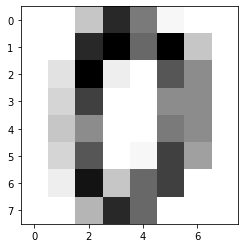

In [18]:
plt.imshow(X[0].reshape(8, 8), cmap=plt.get_cmap("Greys"))

### Build & fit the model

In [19]:
n_features = X_train.shape[1]
# prepare the two layer neural network
model = Sequential()
# we use a purposedly oversized hidden dense layer for the proof of concept.
model.add(Dense(1000, input_shape=(n_features,), activation="relu"))
model.add(Dense(10, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
base_accuracy = model.evaluate(X_test, y_test)[1] * 100
print(f"Base model accuracy: {base_accuracy:.2f}%.")


19/19 [==============================] - 0s 840us/step - loss: 0.0878 - accuracy: 0.9747
Base model accuracy: 97.47%.


## Use the pyfaust library to factorize the network weight matrices into product of sparse matrices

After the network have been trained, we want to extract the weight matrices of the dense layers and compress them
using the `pyfaust` library. The `pyfaust` library provides a simple interface for the PALM4MSA algorithm and its
hierarchical variant. Here we only use the simple PALM4MSA algorithm. The constraint we use for each sparse factor is
called `splincol`. It takes the target sparse factor as input and one parameter which we call the "sparsity level".
It ensures that all the output sparse factors have the right shape and at least "sparsity level" coefficients on each
row and each column.

In [20]:
from pyfaust.fact import palm4msa
from pyfaust.factparams import ParamsPalm4MSA, StoppingCriterion
from pyfaust.proj import splincol

In [21]:

dct_layer_faust_obj_biases = dict()
sparsity_level = 5

for layer in model.layers:
    if not isinstance(layer, Dense):
        # we only want to compress dense layers here
        print(f"Not a dense layer: {layer.__class__.__name__}")
    else:
        weights, biases = layer.get_weights()
        # the "inner" dimension of each sparse factor is the min between the two dimensions of the input weight matrix
        A = min(weights.shape)

        # the number of projectors specifies the number of output sparse factors. Here: 2.
        lst_projs = [
            splincol((weights.shape[0], A),sparsity_level),
            splincol((A, weights.shape[1]), sparsity_level)
        ]

        # 200 iteration is arbitrary and have been shown 
        # to give sufficiently good results
        stop_crit = StoppingCriterion(num_its=200) 

        # the palm4msa function will factorize the weights variable into factors whose constrained are 
        # specified inside the ParamsPalm4MSA object
        param = ParamsPalm4MSA(lst_projs, stop_crit)
        # ret_lambda allows to return the disambiguating scaling factor
        faust_weights = palm4msa(weights.astype(float), param, ret_lambda=True)
        
        dct_layer_faust_obj_biases[layer.name] = (*faust_weights, biases)
        
        

### Show an implementation of a PSM layer that can handle weights expressed in product

To be clear: the proposed implementation isn't purposed to be used in production for model compression. It can't.
The implementation we propose for "PSM"-Dense layers actually contains even more parameters than a classical dense layer.
However, it mimics the computation of sparse factors and it allows us to see that PSM layers are capable to learn to
achieve a given learning task.

In earlier version of tensorflow, it was possible to train actual sparse tensors. However, the implementation with the
SparseTensor class was much slower than this one. It makes sense since `tensorflow` and the GPU modern libraries have
been designed with dense matrices multiplications in mind.


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations

In [23]:
class PSMDense(Layer):
    """
    Layer which implements a sparse factorization with fixed sparsity pattern for all factors.
    The gradient will only be computed for non-zero entries.
    `SparseFactorisationDense` implements the operation:
    `output = activation(dot(input, prod([kernel[i] * sparsity_pattern[i] for i in range(nb_factor)]) + bias)`
    where `activation` is the element-wise activation function
    passed as the `activation` argument.
    """

    def __init__(self, units, sparsity_patterns,
                 activation=None,
                 **kwargs):

        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)

        super(PSMDense, self).__init__(**kwargs)

        # note that the sparsity patterns for the sparse factors are already fixed at init.
        self.sparsity_patterns = sparsity_patterns
        self.nb_factor = len(sparsity_patterns)

        self.units = units
        self.activation = activations.get(activation)

        self.build(input_shape=(None, sparsity_patterns[-1].shape[1]))

    def build(self, input_shape):
        assert len(input_shape) >= 2

        self.kernels = []  # this will contain the actual weights to be learned
        self.sparsity_masks = []  # this will contain the constant mask corresponding to each weight matrix
        for i in range(self.nb_factor):

            kernel = self.add_weight(shape=self.sparsity_patterns[i].shape,
                                     name='kernel_{}'.format(i))
            sparsity_mask = tf.constant(self.sparsity_patterns[i], dtype=tf.float32, name="sparsity_mask_{}".format(i))

            self.kernels.append(kernel)
            self.sparsity_masks.append(sparsity_mask)

        self.bias = self.add_weight(shape=(self.units,),
                                    name='bias')

        super(PSMDense, self).build(input_shape)

    def call(self, inputs):
        output = inputs

        for i in range(self.nb_factor):
            # the pairwise multiplication with the weight matrix make the gradient zero 
            # where the mask has value 0.
            output = tf.matmul(output, self.kernels[i] * self.sparsity_masks[i])

        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def set_weights(self, lst_weights):
        bias = lst_weights[-1]
        # we remove all the weights outside the 1 of the sparsity masks.
        # This doesn't change anything on the actual computation but helps keep things clean and 
        # allows for easier count of non-zero weights.
        super().set_weights([lst_weights[i] * self.sparsity_patterns[i] for i in range(self.nb_factor)] + [bias])


### Build the PSM network, load the factorized weights and finetune

Every dense layer of the initial model is replaced with a PSM version of it. The weights and sparsity masks of the
PSM layers are initialized with the factorized weight matrices from the pretrained network.

In [24]:
new_model = Sequential()

for layer in model.layers:
    if not isinstance(layer, Dense):        
        print(f"Not a dense layer: {layer.__class__.__name__}")
        new_model.add(layer.__class__(**layer.get_config()))
    else:
        (faust_weights, scaling, biases) = dct_layer_faust_obj_biases[layer.name]
        # the sparse factors are cast into np.ndarray so now they are not "sparse" anymore, memory-wise.
        lst_array_faust_weights = [faust_weights.factors(i).toarray() if not isinstance(faust_weights.factors(i), np.ndarray) else faust_weights.factors(i) for i in range(faust_weights.numfactors())]
        # the first sparse factor is rescaled for the full sparse factorization to really 
        # approximate the initial weight matrix
        lst_array_faust_weights[0] = scaling * lst_array_faust_weights[0]
        lst_sparsity_pattern = [elm.astype(bool).astype(float) for elm in lst_array_faust_weights]
        new_layer = PSMDense(layer.units,
                                             sparsity_patterns=lst_sparsity_pattern,
                                             activation=layer.activation)
        new_model.add(new_layer)
        new_layer.set_weights( lst_array_faust_weights + [biases])
new_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
new_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
accuracy_new_model = new_model.evaluate(X_test, y_test)[1] * 100
print(f"New model accuracy: {accuracy_new_model:.2f}")

19/19 [==============================] - 0s 811us/step - loss: 84.0327 - accuracy: 0.9495
New model accuracy: 94.95


In [25]:
def count_nnz_weights(tfk_model):
    """
    Counts the number of non-zero weights in a model.

    :param tfk_model: a tf.keras model.
    :return: int
    """
    total_weight_count = 0
    for layer in tfk_model.layers:
        lst_weights = layer.get_weights()
        for weights in lst_weights:
            # casting a matrix to bool make its coefficients 1 where they were different than 0 and 0 otherwise.
            # summing the "bool-ified" matrix is equivalent to counting the non-zero coffecients
            total_weight_count += np.sum(weights.astype(bool))
    return total_weight_count

In [26]:
nb_weights_base = count_nnz_weights(model)
nb_weights_compressed = count_nnz_weights(new_model)
ratio = nb_weights_base / nb_weights_compressed
print(f"Number of weights in the base model: {nb_weights_base}")
print(f"Number of weights in the compressed model: {nb_weights_compressed}")
print(f"The PSM network has {ratio:.1f} times less non-zero learnable parameters than the base network.")

Number of weights in the base model: 74986
Number of weights in the compressed model: 11443
The PSM network has 6.6 times less non-zero learnable parameters than the base network.
